# Modelo Heterocedastico Serie de Rendimientos

In [3]:
pip install yfinance

In [44]:
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sa
import yfinance as yf
import math
import numpy as np

In [45]:
st.norm.ppf(1-0.05)

1.6448536269514722

In [46]:
apple=yf.Ticker('AAPL')

In [47]:
apple=apple.history(start='2000-01-01',end='2021-07-01')

In [48]:
apple=apple.iloc[:,[3]]

In [49]:
apple.tail()

,Close
Date,
2021-06-24 00:00:00-04:00,131.864731
2021-06-25 00:00:00-04:00,131.568176
2021-06-28 00:00:00-04:00,133.218857
2021-06-29 00:00:00-04:00,134.750916
2021-06-30 00:00:00-04:00,135.373611


In [50]:
apple.dropna(inplace=True)

In [51]:
apple.shape

(5408, 1)

In [52]:
apple['Rendimientos_log']=np.log(apple['Close']/apple['Close'].shift(1))#shift recorre una posicion anterior, aemas se calcula el ln

In [53]:
apple=apple[(apple.index>='2007-01-04')&(apple.index<='2021-07-23')]

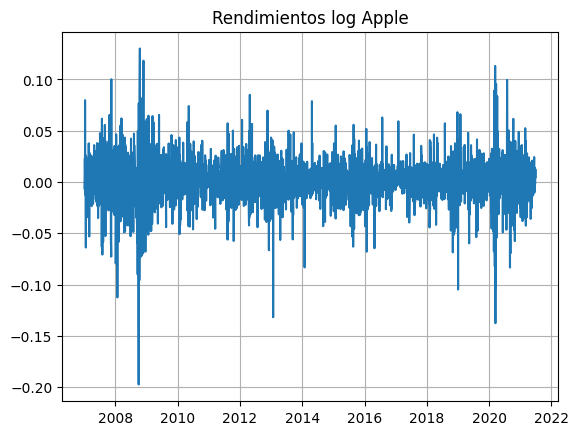

In [54]:
plt.plot(apple['Rendimientos_log'])
plt.title('Rendimientos log Apple')
plt.grid()
plt.show()


## Cálculo del VaR
calculo por cuantiles, asumiendo la siguiente confianza para los VaR:

90%,95%,99%, 99.9%

In [55]:
VaR=dict(zip(['90%','95%','99%','99.9%'],np.quantile(apple['Rendimientos_log'],[.90,0.95,.99,.999])))

In [56]:
VaR#estos son los valores en riesgo de las distintas posiciones

{'90%': 0.022806386637803277,
 '95%': 0.0314924282443481,
 '99%': 0.0572303923809291,
 '99.9%': 0.09977748585773147}

## Cálculo del CVaR al 95%

In [57]:
#ordenar los rendiminetos en orden ascendente, para dejar desde donde hubo mas perdida hasta donde hubo mayor ganancia
ap=apple[['Rendimientos_log']]
ap=ap.sort_values(by='Rendimientos_log')

In [58]:
int(len(ap)*.95)#quantil del 95%

3465

In [86]:
ap.iloc[3464,[0]]

Rendimientos_log    0.031476
Name: 2008-02-27 00:00:00-05:00, dtype: float64

In [87]:
#con el dato anterior se calcula el promedio de los datos mayores o iguales al VaR
es=ap.iloc[3464:,[0]].sum()/(len(ap)-3465)

In [61]:
es#este es el var del valor dela serie

Rendimientos_log    0.047136
dtype: float64

In [62]:
VaR

{'90%': 0.022806386637803277,
 '95%': 0.0314924282443481,
 '99%': 0.0572303923809291,
 '99.9%': 0.09977748585773147}

Cuando se compara el var condicional que es "es" con respecto a "VaR", se ve que el var condicional tiene una capacidad mayor para identificar perdidas, ya que al 95% identifica 0.0471 o 4.7% y el otro 3.14%. Es decir que la maxíma perdida esperada con VaR con un 95% de confianza es 3.14%

##VaR Gaussiano o normal, histórico o no paramétrico y modificado
Var=cantidad_posicion*valor_x_dist*raiz(horizonte_temp)*deviación_Std_t-1

In [63]:
#normal 95%
VaRN=st.norm(loc=apple['Rendimientos_log'].mean(),scale=apple['Rendimientos_log'].std()).ppf([1-.95])
VaRN

array([-0.03254659])

In [64]:
#alternativa2
#st.norm().ppf(.05)*apple['Rendimientos_log'].std()
#alternativa 3
#cun=st.norm.ppf(1-.95)
#cun*-(apple['Rendimientos_log'].std())

In [65]:
#Historico o monte carlo genera multiples trayectorias aletarorias de rendimientos futuros usando una dist que se ajusta a hist
simulacion_R=np.random.choice(apple.Rendimientos_log,size=(100,len(apple)),replace=True)
rend_acum=np.cumprod(simulacion_R,axis=1)#con axis 1 suma columnas
VaR_mont=-np.quantile(rend_acum[0,:],0.95)
VaR_mont

-0.0

In [66]:
rend_acum

array([[ 2.78044058e-02,  8.67226603e-04, -5.42899907e-06, ...,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.75926944e-02,  1.76210934e-04,  4.11428921e-07, ...,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-5.72139046e-02, -7.03222770e-04,  1.21388497e-05, ...,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       ...,
       [-6.70068920e-03,  2.75665597e-05, -5.76850660e-07, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 4.03785485e-02, -1.52988182e-04,  8.82455444e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.53479861e-02, -6.02952211e-04, -3.83575334e-06, ...,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00]])

##CVaRN Normal
El cvar sirve con distribuciones leptocurticas con colas gordas

In [67]:
VaRN=st.norm(loc=apple['Rendimientos_log'].mean(),scale=apple['Rendimientos_log'].std()).ppf(.05)
VaRN

-0.032546593231613956

In [68]:
dist_n=st.norm(loc=apple['Rendimientos_log'].mean(),scale=apple['Rendimientos_log'].std()).rvs(len(apple))

In [69]:
VaRN=np.quantile(dist_n,.05)

In [70]:
VaRN

-0.03272443271501171

In [71]:
CVaRN=dist_n[dist_n<VaRN].mean()

In [72]:
CVaRN#capta mas riesgo que el VARN normal solo que capta un 3.26 aprox

-0.04204780215486923

## VaR Medias Moviles 500

In [73]:
def varn(x):
  VaRN=-st.norm(loc=x.mean(),scale=x.std()).ppf(.95)
  return VaRN


In [74]:
def var_h(x):
  varh=-np.quantile(x,.95)
  return varh

In [75]:
def var_mc(x):
  simulacion_R=np.random.choice(x,size=(500,len(x)),replace=True)
  rend_acum=np.cumprod(simulacion_R,axis=1)#con axis 1 suma columnas
  VaR_mont=-np.percentile(rend_acum[:,-1],5)
  return VaR_mont

In [76]:
def cvar(x):
  n=np.quantile(x,.95)
  cvar=-x[x>=n].mean()
  return cvar

In [77]:
def cvarnorm(x):
  dist_n=st.norm(loc=x.mean(),scale=x.std()).rvs(len(x))
  n=np.quantile(dist_n,.05)
  cvarn=dist_n[dist_n<n].mean()
  return cvarn

In [78]:
apple=apple[['Rendimientos_log']]

In [79]:
apple['VaR N']=apple['Rendimientos_log'].rolling(500).apply(lambda x: varn(x))
apple['VaR H']=apple['Rendimientos_log'].rolling(500).apply(lambda x: var_h(x))

apple['CVaR H']=apple['Rendimientos_log'].rolling(500).apply(lambda x:cvar(x))
apple['CVaR N']=apple['Rendimientos_log'].rolling(500).apply(lambda x:cvarnorm(x))

In [80]:
#apple['VaR MC']=apple['Rendimientos_log'].rolling(500).apply(lambda x: var_mc(x))

<Axes: xlabel='Date'>

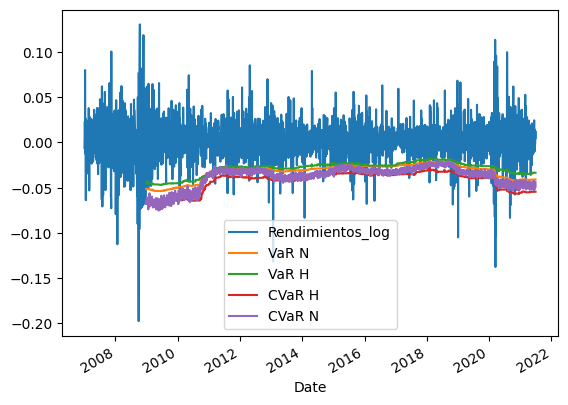

In [81]:
apple.plot()

In [82]:
4000*st.norm.ppf(.95)*math.sqrt(3)*(0.70/100)#perdida potencial en 3 dias

79.77116148102903

In [83]:
4000*st.norm.ppf(.95)*math.sqrt(1)*(0.70/100)#perdida potencial en 1 dia

46.05590155464122

In [84]:
st.norm.ppf(.95)*(.70/100)

0.011513975388660305